### Задача 5. Обучение без учителя

- Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте один из алгоритмов кластеризации, например K-means.
- Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из sklearn (KMeans, Affinity Propogation, DBSCAN и тд). При обучении использовать подбор гиперпараметров.
- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.

- (+3 балла) Также снизить размерность данных с помощью метода главных компонент PCA и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.

- (+2 балла) Визуализировать данные снижением размерности до 2 или 3 с помощью PCA и t-SNE. В случае проблем с производительностью t-SNE, можно сначала до какой то степени снизить размерность с помощью PCA, а затем запустить t-SNE.

In [45]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 16.8 MB/s eta 0:00:00


In [106]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from itertools import product

### Датасет

[Students' Social Network Profile Clustering](https://www.kaggle.com/datasets/zabihullah18/students-social-network-profile-clustering/data) включает в себя случайную выборку из 15 000 учеников старших классов, которые вели профили на популярной платформе социальных сетей в период с 2006 по 2009 год. Данные собирались равномерно в течение этих лет.

Набор данных включает подсчеты 37 наиболее распространенных слов, найденных в профилях, таких как «футбол» и «шопинг», что указывает на распространенность различных тем среди учащихся.

Помимо данных, связанных с интересами, набор данных также включает важную демографическую информацию о каждом ученике, включая год окончания учебы (gradyear), пол, возраст на момент опроса и количество контактов или друзей, которые были у них в социальной сети (NumberOffriends)



In [2]:
df = pd.read_csv('/content/03_Clustering_Marketing.csv')
df.head()

,gradyear,gender,age,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2007,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2007,F,17.41,49,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2007,F,17.511,41,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
3,2006,F,NaN,36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2008,F,16.657,1,0,0,0,0,0,1,...,0,0,0,3,0,0,0,0,0,0


In [3]:
df.shape

(15000, 40)

### EDA

In [4]:
df.describe()

,gradyear,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,2007.496933,29.834533,0.267000,0.255467,0.22200,0.159667,0.142933,0.135000,0.105133,0.104133,...,0.112867,0.259467,0.357267,0.150267,0.071800,0.051467,0.185867,0.118067,0.091733,0.061067
std,1.116516,35.386649,0.788851,0.702260,0.92042,0.737344,0.638747,0.548691,0.502491,0.519205,...,2.708619,0.704398,0.728512,0.478716,0.356258,0.280755,0.609928,0.455200,0.420631,0.349112
min,2006.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2006.000000,3.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2008.000000,20.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2008.000000,44.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2009.000000,605.000000,22.000000,9.000000,22.00000,17.000000,14.000000,31.000000,8.000000,14.000000,...,327.000000,12.000000,11.000000,8.000000,8.000000,8.000000,16.000000,14.000000,8.000000,16.000000


Из данных видно, что нам нужно будет масштабировать большинство числовых столбцов.

In [5]:
df.dtypes

,0
gradyear,int64
gender,object
age,object
NumberOffriends,int64
basketball,int64
football,int64
soccer,int64
softball,int64
volleyball,int64
swimming,int64


In [6]:
df.isnull().sum()

,0
gradyear,0
gender,1337
age,2496
NumberOffriends,0
basketball,0
football,0
soccer,0
softball,0
volleyball,0
swimming,0


In [8]:
df['gender'].value_counts(dropna = False)

,count
gender,
F,11057
M,2606
NaN,1337


Заменим NaN-ы на какое-нибудь другое категориальное значение

In [10]:
df['gender'].fillna('N', inplace = True)

<ipython-input-10-a73aa70815b4>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['gender'].fillna('N', inplace = True)


In [12]:
df['gender'].isnull().sum()

np.int64(0)

Сразу преобразуем этот признак в числовой (для визуализации данных, а также для предобработки, чтоб передать данные в модели)

In [13]:
df['gender'] = df['gender'].map( {'F': 0, 'M': 1, 'N': 2} ).astype(int)

In [14]:
df['gender'].value_counts(dropna = False)

,count
gender,
0,11057
1,2606
2,1337


NaN-ы в колонке 'age' заполним средним возрастом каждого года выпуска, предварительно преобразовав в числовой тип

In [17]:
df['age'] = pd.to_numeric(df['age'])

In [15]:
df.groupby('gradyear')['age'].mean()

,age
gradyear,
2006,19.010786
2007,18.400134
2008,17.593006
2009,16.886244


In [18]:
df['age'] = df.groupby('gradyear')['age'].transform(lambda x: x.fillna(x.mean()))

In [20]:
df['age'].isnull().sum()

np.int64(0)

Cтандартизируем диапазон входных данных

In [24]:
scaler = MinMaxScaler().fit(df)
features = scaler.transform(df)
pd.DataFrame(features, columns=df.columns).head()

,gradyear,gender,age,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0.333333,1.0,0.137316,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0000
1,0.333333,0.0,0.127668,0.080992,0.0,0.0,0.045455,0.0,0.0,0.032258,...,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.125,0.0000
2,0.333333,0.0,0.128652,0.067769,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.083333,0.0,0.000,0.0,0.0,0.0,0.0,0.125,0.0625
3,0.000000,0.0,0.143267,0.059504,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0000
4,0.666667,0.0,0.120330,0.001653,0.0,0.0,0.000000,0.0,0.0,0.032258,...,0.0,0.000000,0.0,0.375,0.0,0.0,0.0,0.0,0.000,0.0000


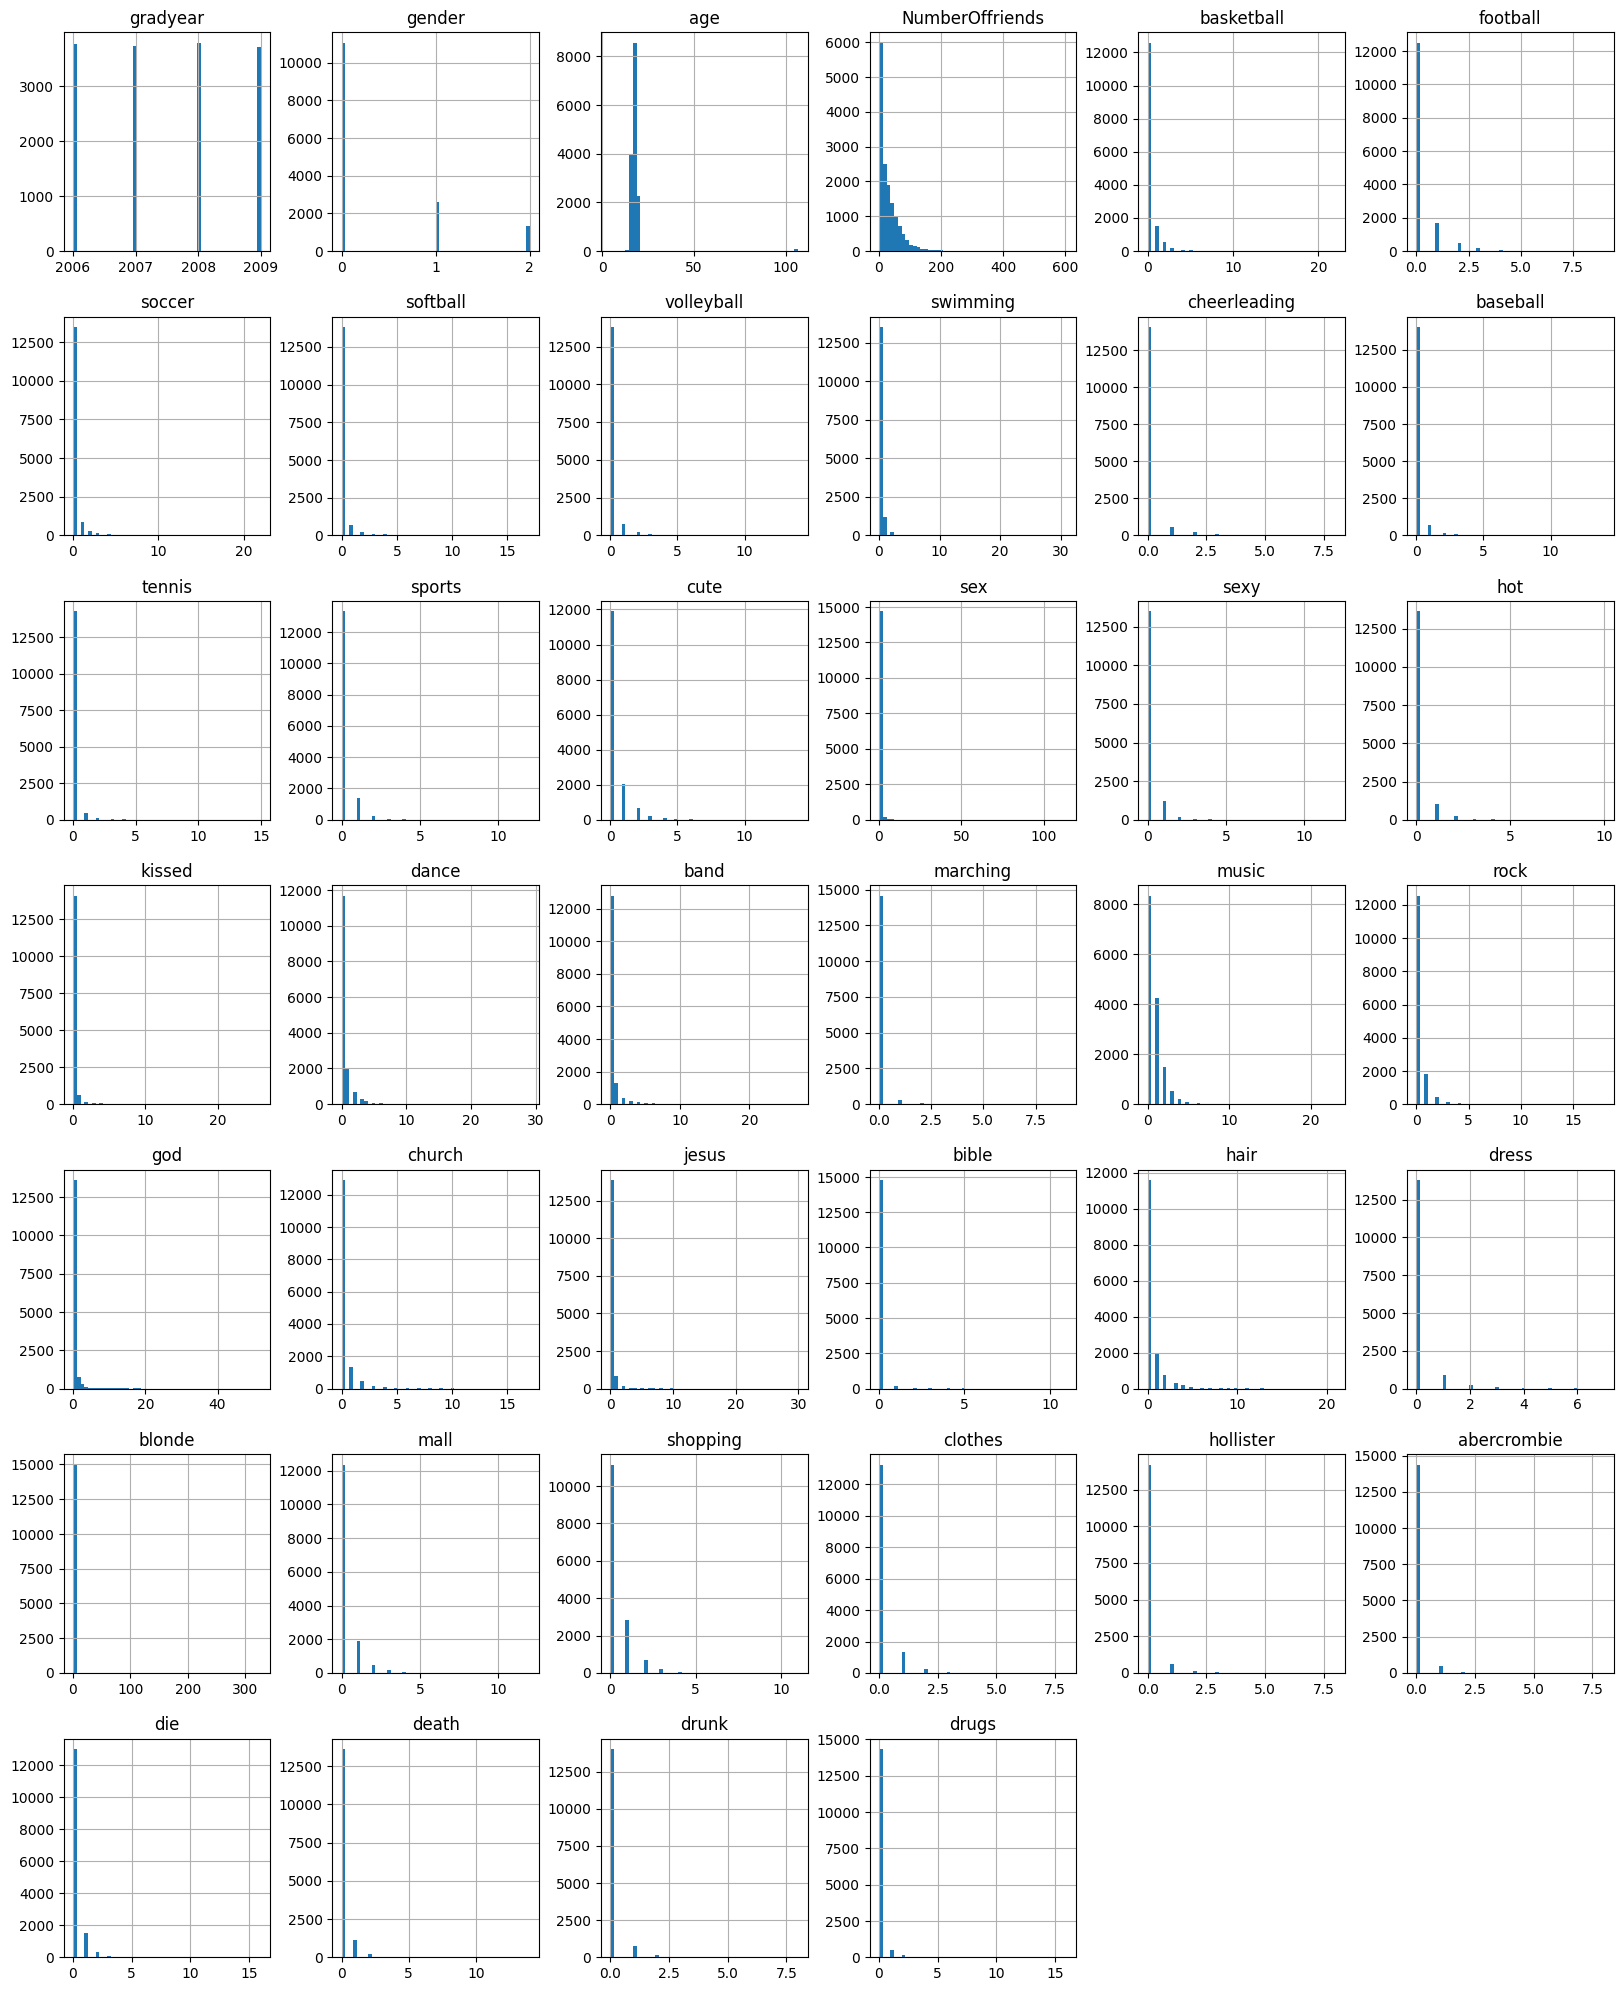

In [37]:
df.hist(figsize=(20, 25), bins = 50)
plt.show()

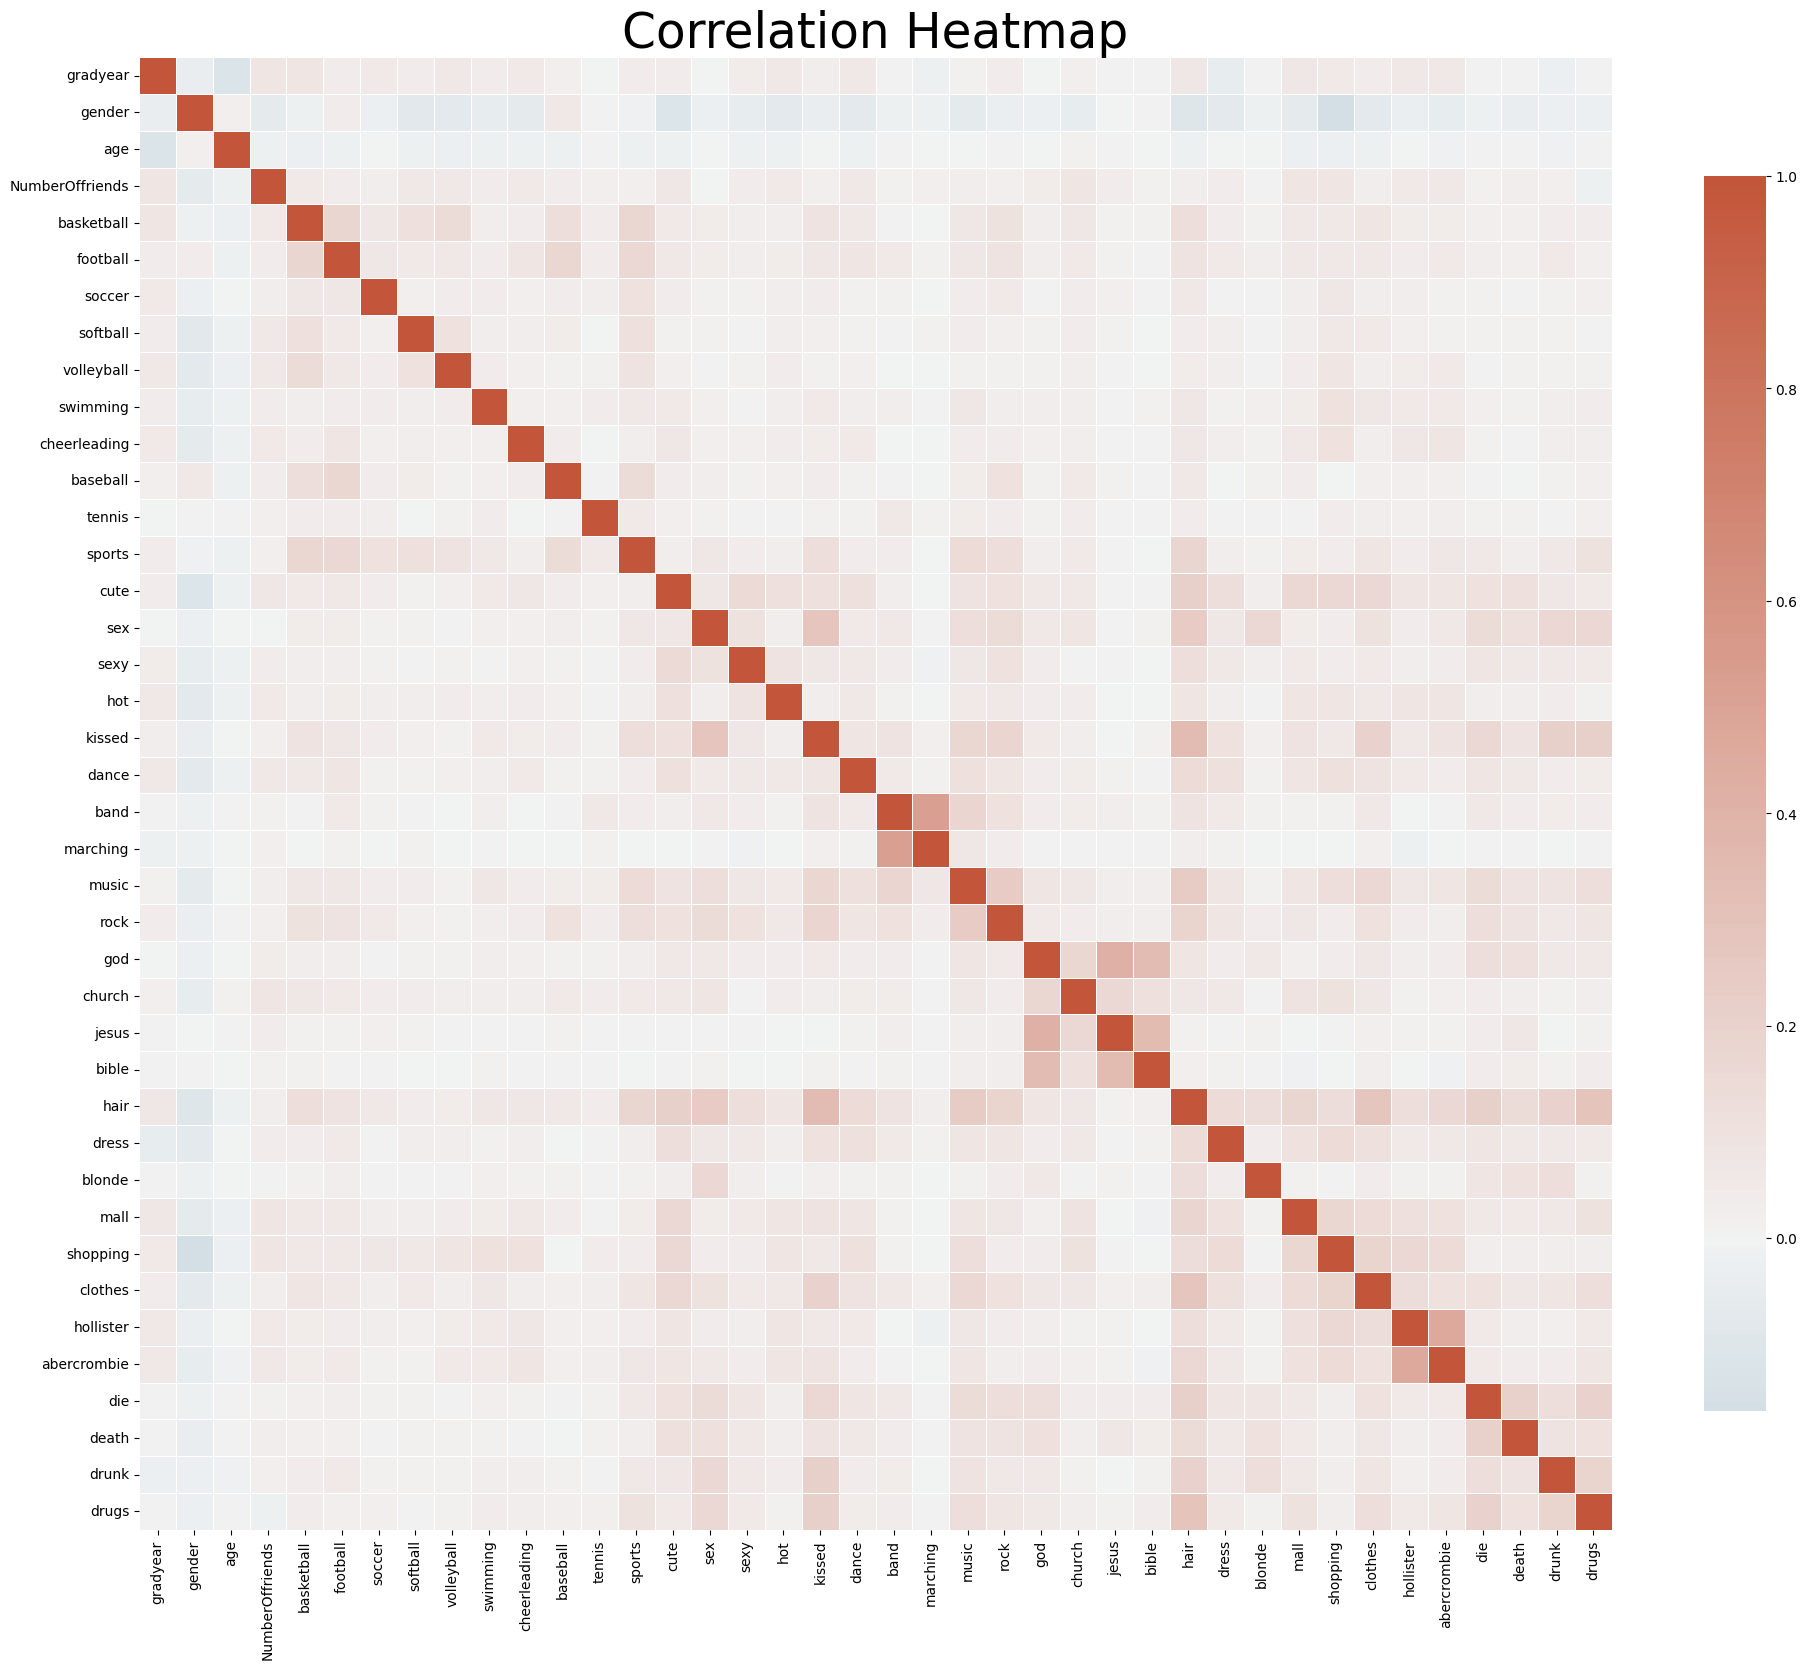

In [36]:
f,ax = plt.subplots(figsize=(20, 25))

mat = df.corr('pearson')
cmap = sns.diverging_palette(230,20,as_cmap=True)
sns.heatmap(mat,cmap=cmap,vmax=1,center=0,square=True,linewidths=.5,cbar_kws={"shrink":.5})
plt.title('Correlation Heatmap',fontsize=35)
plt.tight_layout()
plt.show()

Между признаками нет сильной корреляции, так что не будем ничего удалять

### Elbow Method

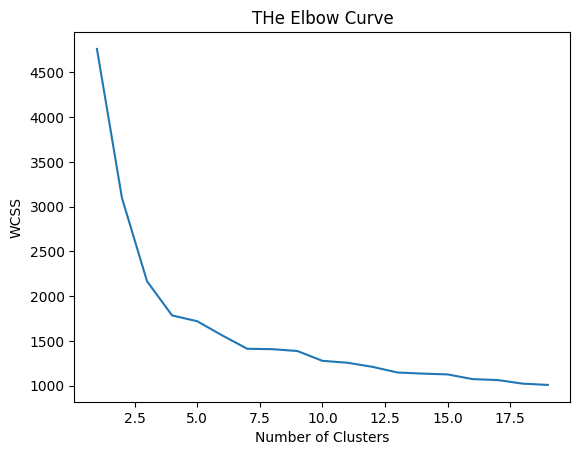

In [27]:
wcss = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i,init='k-means++' ,max_iter=300,random_state=0)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,20),wcss)
plt.title('THe Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel("WCSS")
plt.show()

Точка локтя находится около размера кластера 4, поэтому будем использовать k=4 для дальнейшей кластеризации.

### PCA

In [74]:
X_train, X_test = train_test_split(df, test_size=0.3, shuffle=True, random_state=42)

In [75]:
scaler = MinMaxScaler().fit(df)

In [76]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

In [77]:
pca = PCA(n_components=4, random_state=42)
X_train_pca = pca.fit_transform(scaled_X_train)
X_test_pca = pca.transform(scaled_X_test)

<ipython-input-80-42ac4b569a60>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(x, y, alpha=1, s=20, cmap=plt.cm.get_cmap('plasma'))
<ipython-input-80-42ac4b569a60>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, alpha=1, s=20, cmap=plt.cm.get_cmap('plasma'))


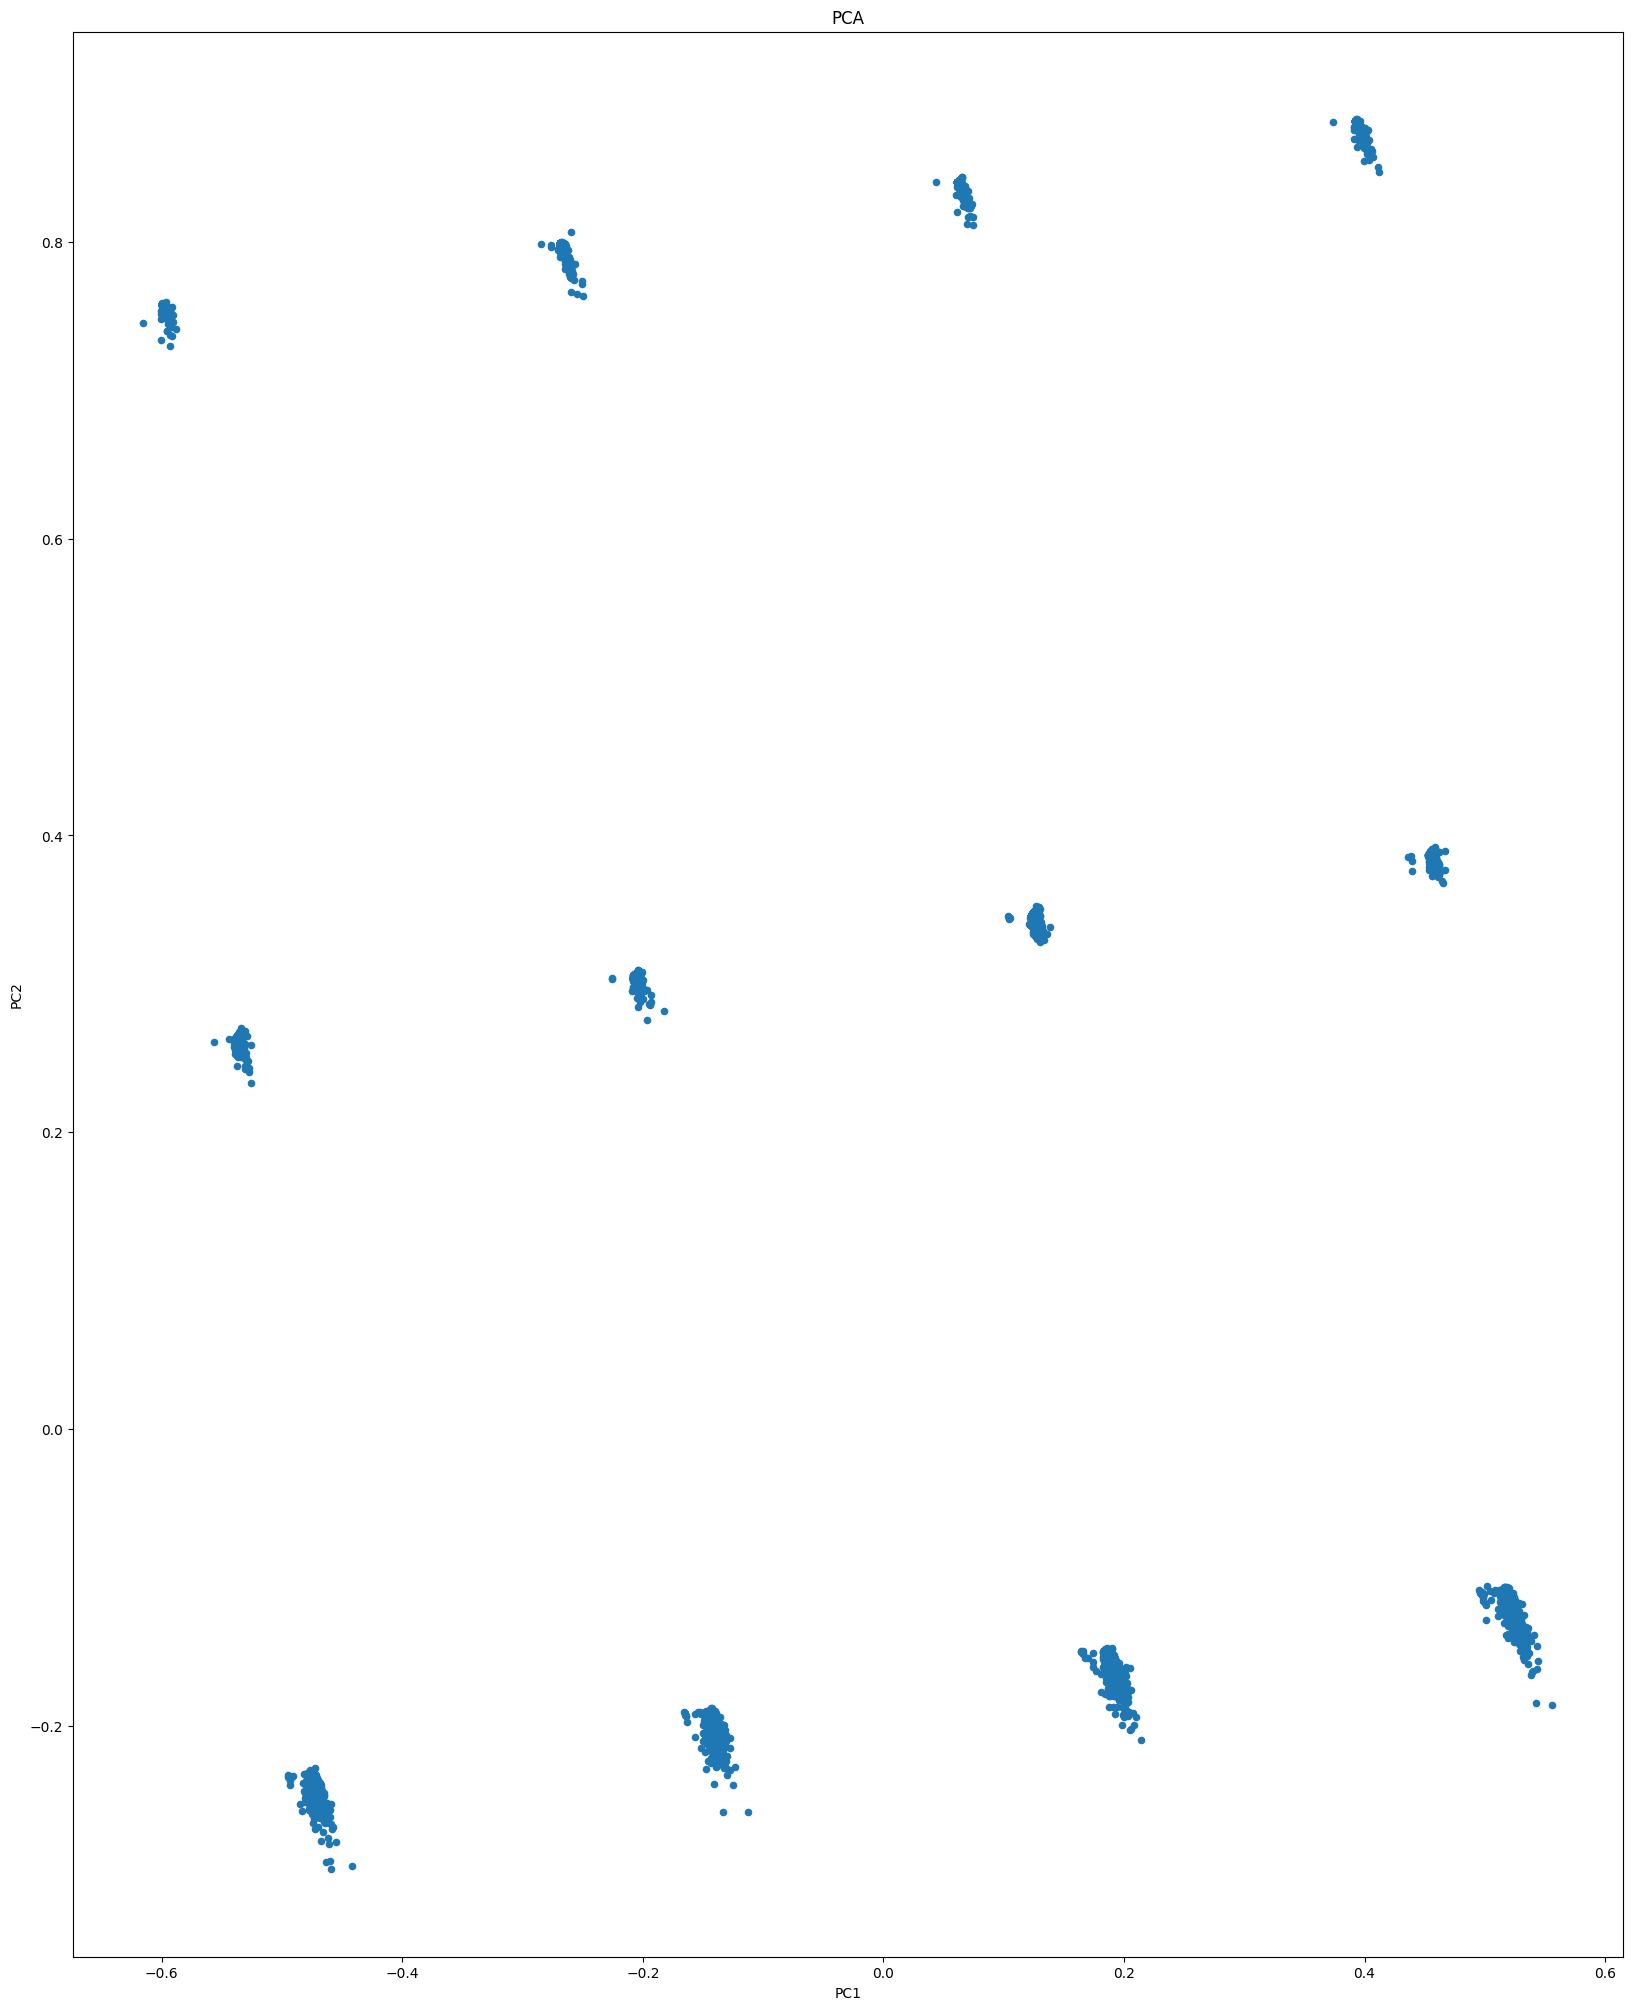

In [80]:
x, y = X_train_pca[:, 0], X_train_pca[:, 1]
plt.figure(figsize=(20, 25))
plt.scatter(x, y, alpha=1, s=20, cmap=plt.cm.get_cmap('plasma'))

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA');
plt.show()

### t-SNE

In [81]:
tsne = TSNE(random_state=42)
tsne = tsne.fit_transform(scaled_X_train)

In [82]:
x, y = tsne[:, 0], tsne[:, 1],

<ipython-input-84-ea2e1acacaa2>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(x, y, alpha=1, s=20, cmap=plt.cm.get_cmap('plasma'))
<ipython-input-84-ea2e1acacaa2>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, alpha=1, s=20, cmap=plt.cm.get_cmap('plasma'))


Text(0.5, 1.0, 't-SNE')

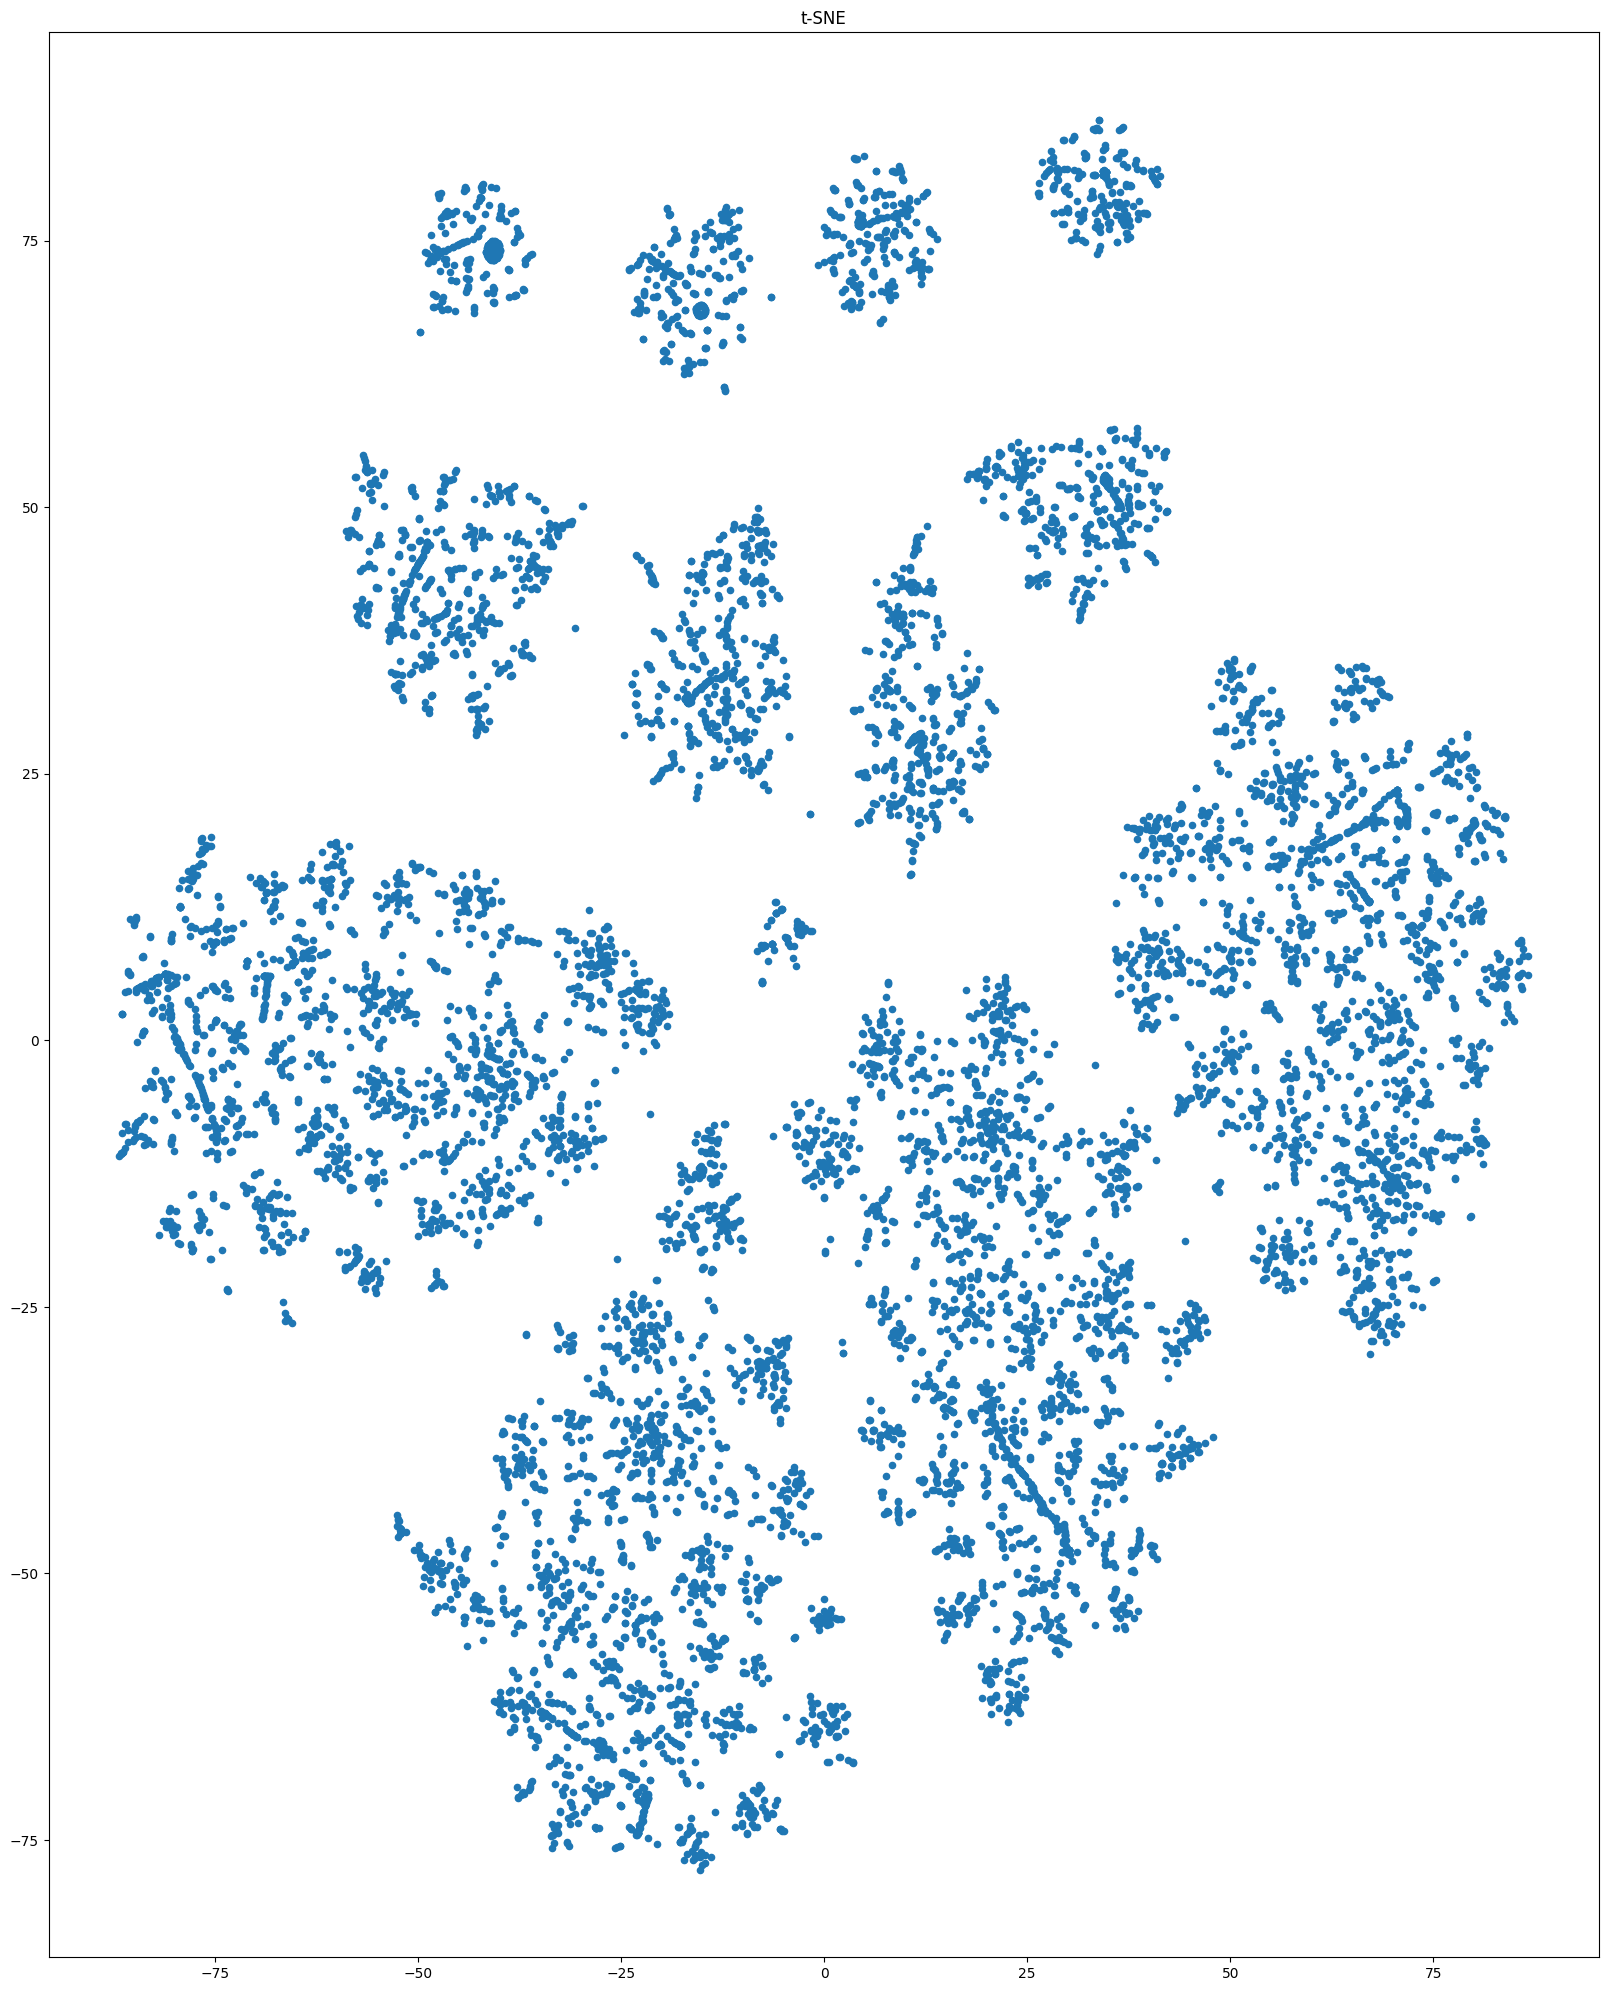

In [84]:
plt.figure(figsize=(20, 25))
plt.scatter(x, y, alpha=1, s=20, cmap=plt.cm.get_cmap('plasma'))
plt.title("t-SNE")

### Реализация метода K-Means

In [85]:
class CustomKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=4, max_iter=500, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X, targets = None):
        if isinstance(X, pd.DataFrame):
            X = X.values
        np.random.seed(42)
        random_idxs = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_idxs]

        for i in range(self.max_iter):
            clusters = self._assign_clusters(X)
            new_centroids = np.array([X[clusters == j].mean(axis=0) for j in range(self.n_clusters)])
            if np.linalg.norm(self.centroids - new_centroids) < self.tol:
                break
            self.centroids = new_centroids
        return self

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        return self._assign_clusters(X)

    def _assign_clusters(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

### Сравнение моделей

In [116]:
param_grid = {
    'KMeans': {
        'init': ['k-means++', 'random'],
        'max_iter': [100, 500, 1000, 2000]
    },
    'DBSCAN': {
        'eps': [0.3, 0.5, 0.8, 1.0],
        'min_samples': [3, 5, 7]
    },
    'CustomKMeans': {
        'max_iter': [100, 500, 1000, 2000],
        'tol': [1e-2, 1e-4, 1e-6]
    }
}

def get_model_score(model, params, X_train, X_test, dbscan=False):
    grid = GridSearchCV(model, params, cv=3, n_jobs=-1, scoring='adjusted_mutual_info_score')
    grid.fit(X_train)
    scores = dict()
    model = model.set_params(**grid.best_params_)

    start = datetime.now()
    if dbscan:
        labels = model.fit_predict(X_train)
    else:
        model.fit(X_train)
        labels = model.predict(X_train)
    end = datetime.now()

    silhouette = silhouette_score(X_train, labels)
    calinski_harabasz = calinski_harabasz_score(X_train, labels)

    scores['silhouette'] = silhouette
    scores['calinski_harabasz'] = calinski_harabasz
    scores['training_time'] = end - start

    return scores

In [119]:
model = CustomKMeans()
params = param_grid['CustomKMeans']
score = get_model_score(model, params, X_train, X_test)
pca_score = get_model_score(model, params, X_train_pca, X_test_pca)
results = [score, pca_score]
df_customkmeans = pd.DataFrame.from_records(results)
df_customkmeans['model'], df_customkmeans['pca'] = 'CustomKMeans', ['no_pca', 'pca']
print(df_customkmeans)

model = KMeans()
params = param_grid['KMeans']
score = get_model_score(model, params, X_train, X_test)
pca_score = get_model_score(model, params, X_train_pca, X_test_pca)
results = [score, pca_score]
df_kmeans = pd.DataFrame.from_records(results)
df_kmeans['model'], df_kmeans['pca'] = 'KMeans', ['no_pca', 'pca']
print(df_kmeans)

model = DBSCAN()
params = param_grid['DBSCAN']
score = get_model_score(model, params, X_train, X_test, dbscan=True)
pca_score = get_model_score(model, params, X_train_pca, X_test_pca, dbscan=True)
results = [score, pca_score]
df_dbscan = pd.DataFrame.from_records(results)
df_dbscan['model'], df_dbscan['pca'] = 'DBSCAN', ['no_pca', 'pca']
print(df_dbscan)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


   silhouette  calinski_harabasz          training_time         model     pca
0    0.531597       15046.700589 0 days 00:00:00.196534  CustomKMeans  no_pca
1    0.431099        8609.323292 0 days 00:00:00.042412  CustomKMeans     pca


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


   silhouette  calinski_harabasz          training_time   model     pca
0    0.478887       17909.202379 0 days 00:00:00.071974  KMeans  no_pca
1    0.579091       11953.785364 0 days 00:00:00.011953  KMeans     pca


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


   silhouette  calinski_harabasz          training_time   model     pca
0   -0.532950           7.327804 0 days 00:00:00.579990  DBSCAN  no_pca
1    0.646664       12444.166344 0 days 00:00:00.532659  DBSCAN     pca


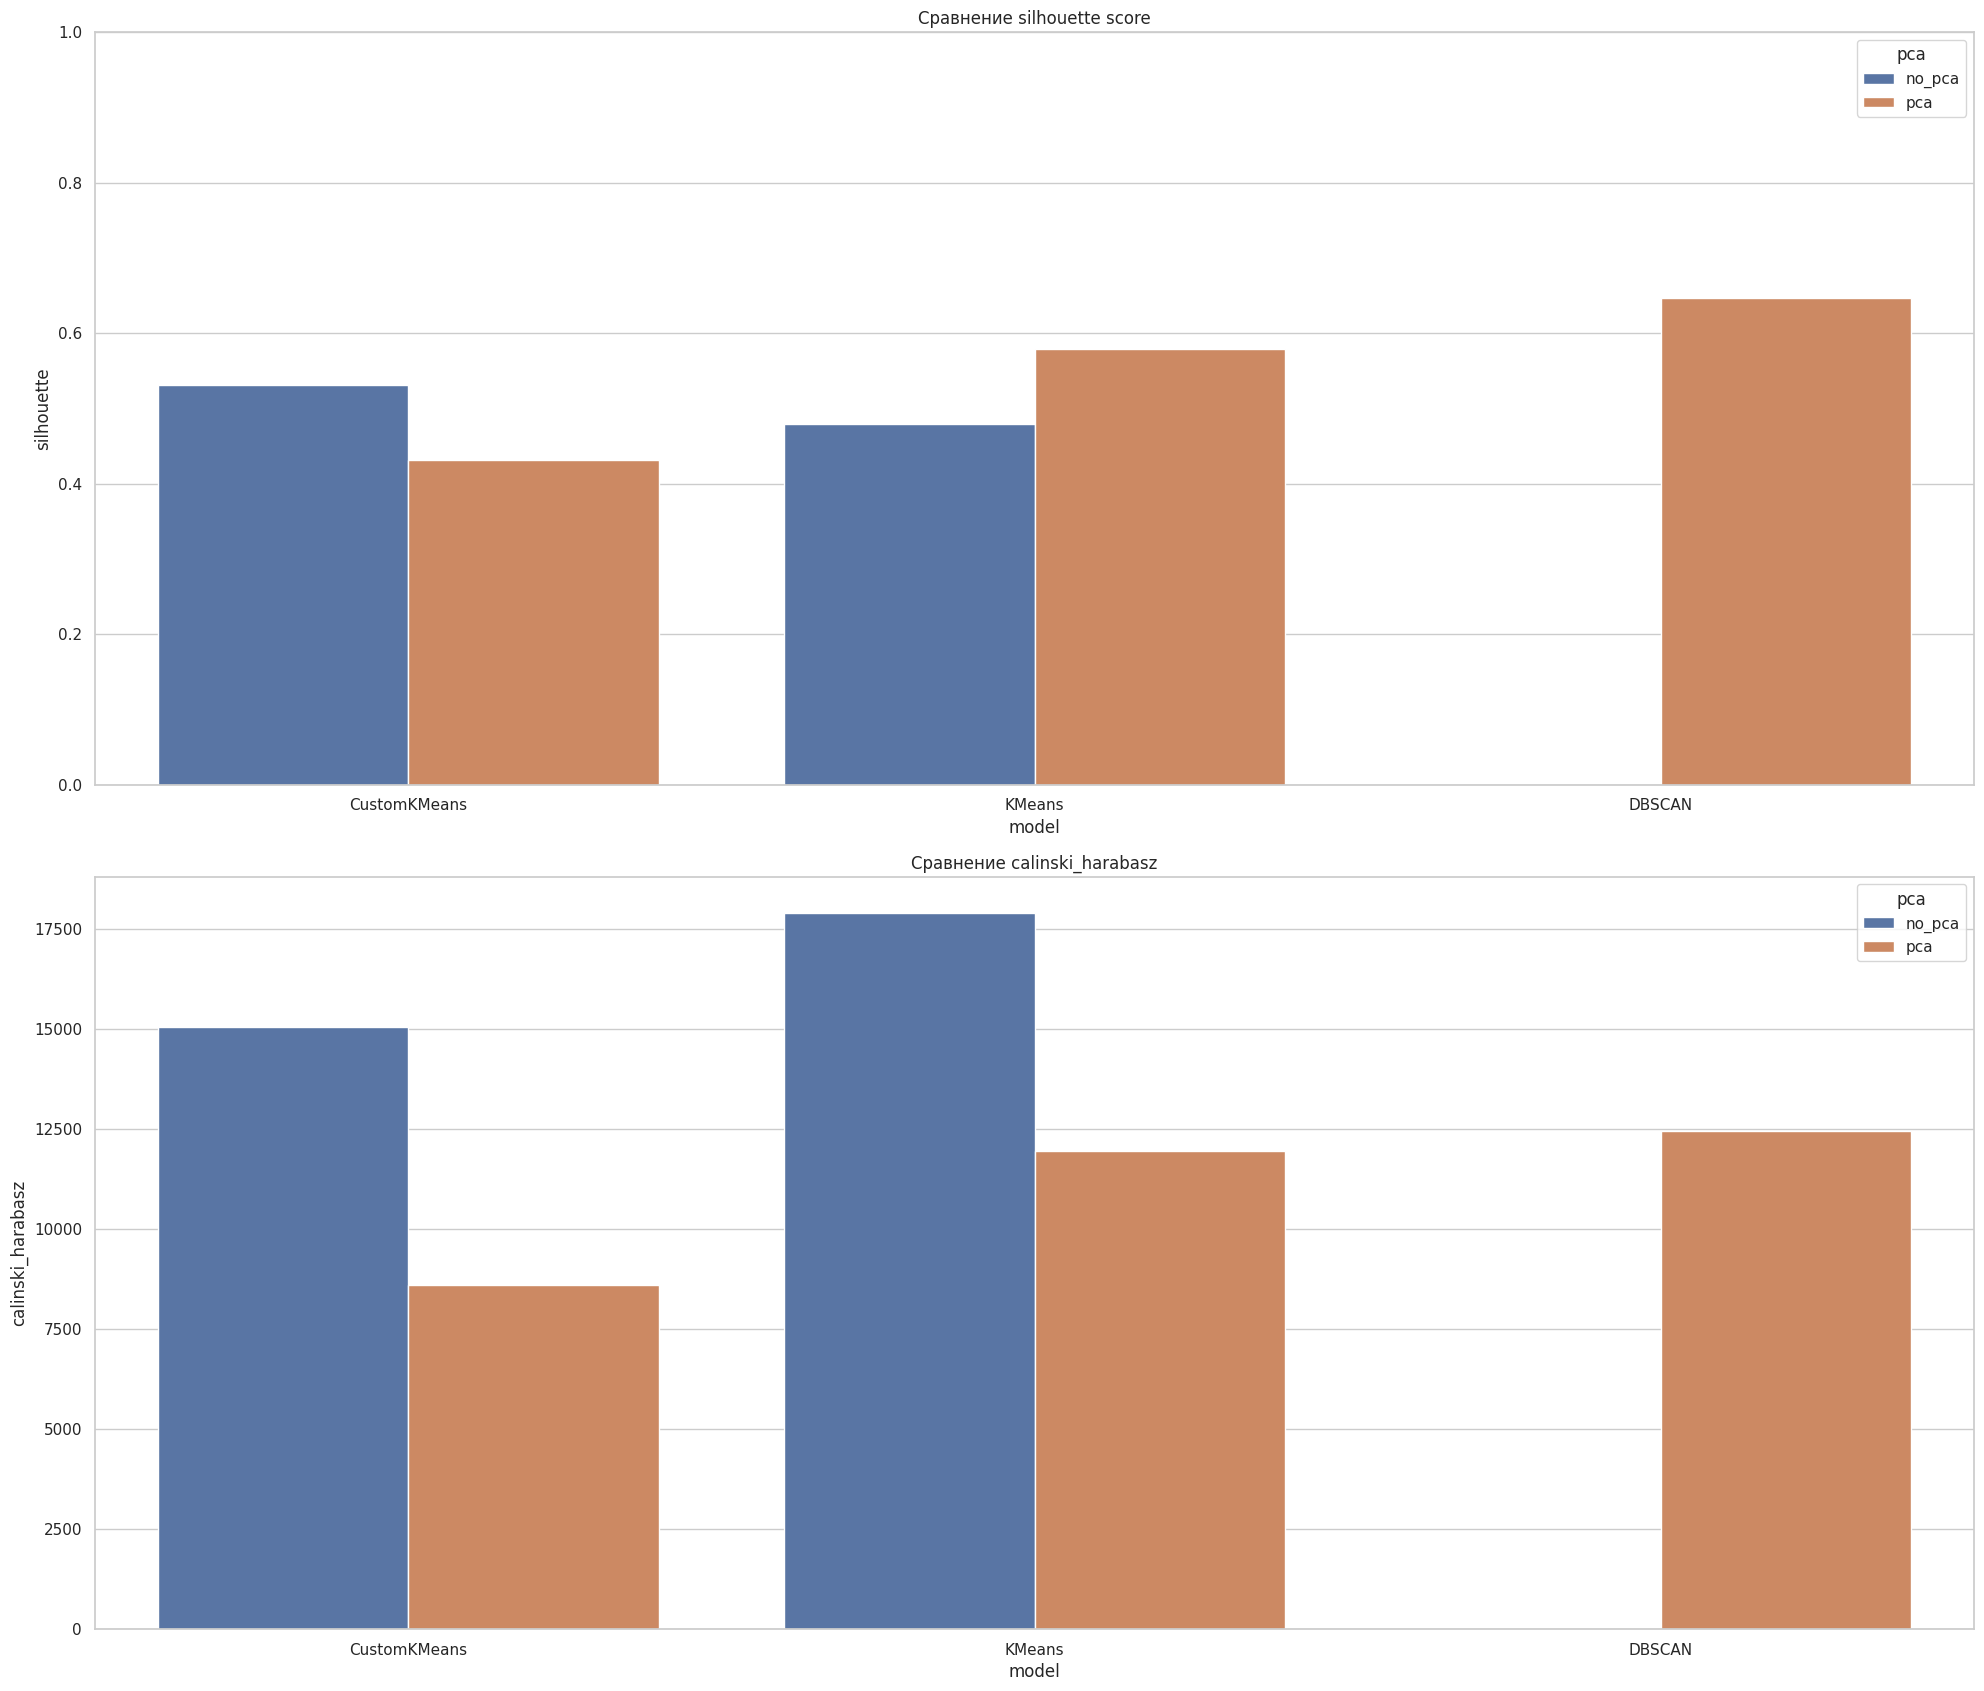

In [129]:
final_df = pd.concat([df_customkmeans, df_kmeans, df_dbscan], ignore_index=True)

plt.figure(figsize=(20, 25))
sns.set_theme(style="whitegrid")

plt.subplot(3, 1, 1)
sns.barplot(x='model', y='silhouette', hue='pca', data=final_df)
plt.title('Сравнение silhouette score')
plt.ylim(0, 1)

plt.subplot(3, 1, 2)
sns.barplot(x='model', y='calinski_harabasz', hue='pca', data=final_df)
plt.title('Сравнение calinski_harabasz')

plt.tight_layout()
plt.show()

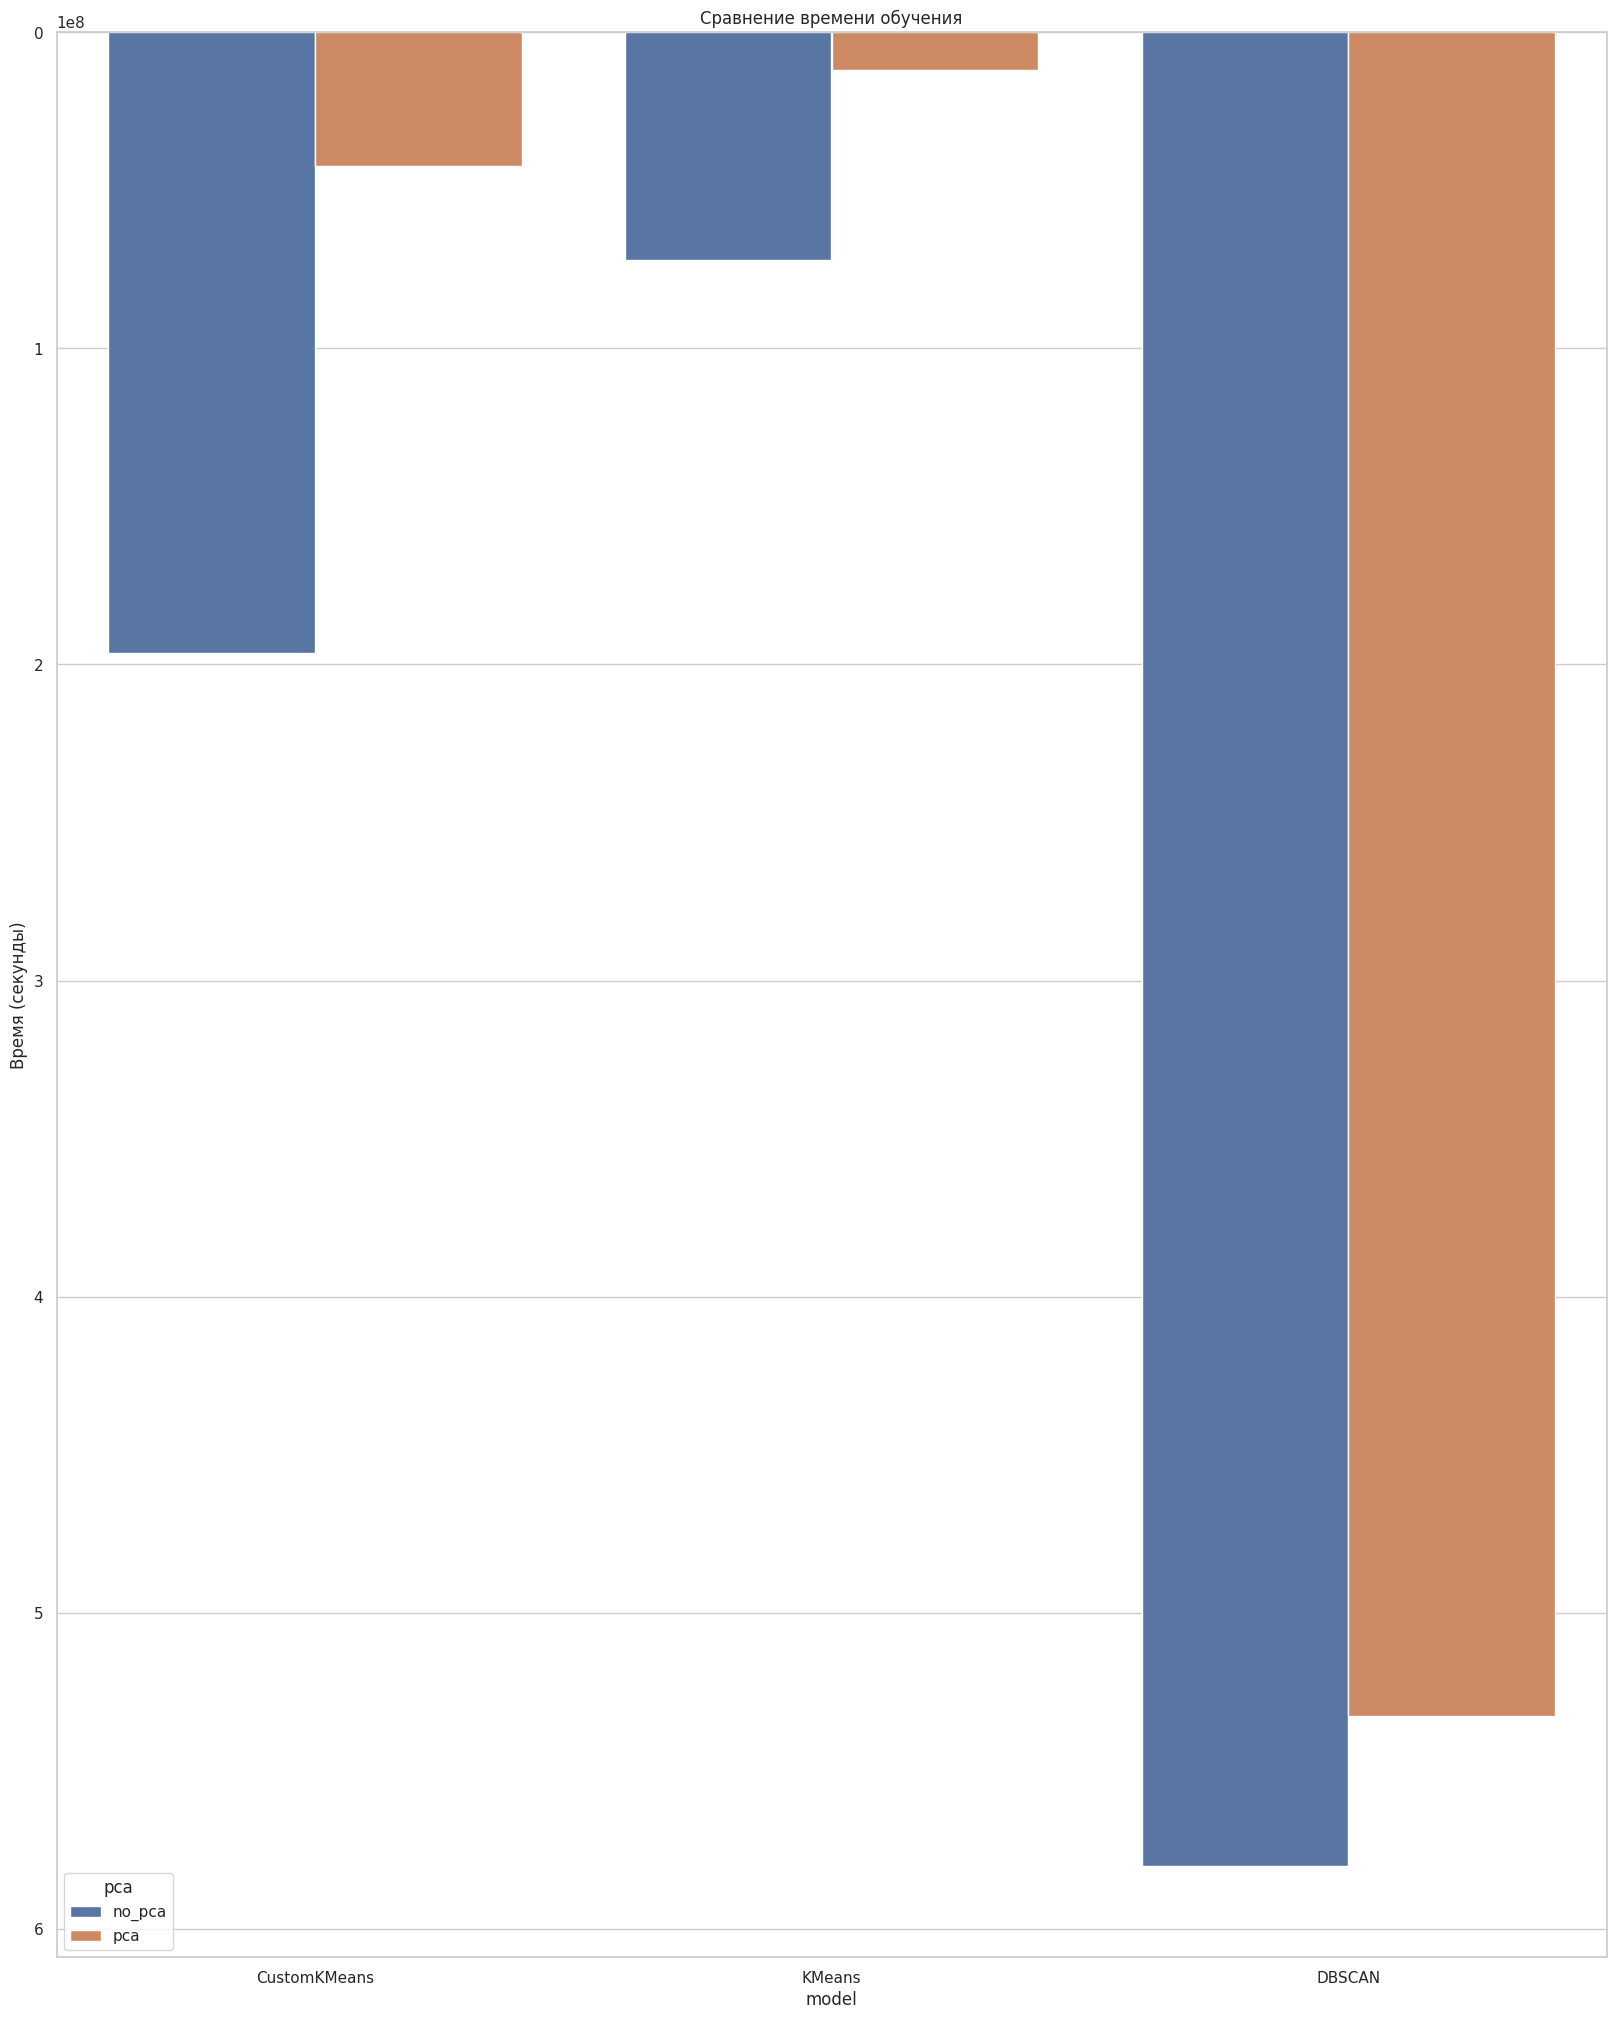

In [135]:
plt.figure(figsize=(20, 25))
sns.barplot(x='model', y='training_time', hue='pca', data=final_df)
plt.title('Сравнение времени обучения')
plt.ylabel('Time (sconds)')
plt.show()

### Выводы

Лучшим алгоритмом по качеству кластеризации оказался DBSCAN с уменьшением размерности входных данных с помощью PCA (если не уменьшать, то он работает дольше). Об этом указывает метрика Silhouette с значением **0.646664**. Однако метрика Calinski and Harabasz показала, что лучше с задачей кластеризации справляется алгоритм KMeans без уменьшения размерности.

Самым быстрым алгоритмом оказался KMeans, а самым долгим - DBSCAN.